# Project 5: Optimal Vehicle State Estimation

Max Schrader

In [1]:
from IPython.display import display

import sympy
import dubins
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

sympy.init_printing(use_latex='mathjax')
pio.templates.default = "ggplot2"
pio.renderers.default = "plotly_mimetype"

### Importing my code from src/ because I miss VSCode Intellisense

In [2]:
from src.helpers import calculate_dubins, RAD_2_DEGREE, confidence_ellipse, normalize_radians
from src.ekf import EKF
from src.base import LTI, Radar

## Finding Dubin's Path

In [3]:
R_path = 5  # given
q0 = (0, -15, -90)
q1 = (-5, 20, -180)

In [4]:
optimal_path = calculate_dubins(q0, q1, R_path, 0.01)

In [5]:
len(optimal_path)

5519

In [6]:
def plot_dubin(*args):
    fig = go.Figure()
    
    for name,  mode, path_list, in args:
        _x = [p[0] for p in path_list]
        _y = [p[1] for p in path_list]
        _theta = [p[2] * RAD_2_DEGREE for p in path_list]
        
        fig.add_trace(
            go.Scatter(
                x=_x,
                y=_y,
                text=_theta,
                name=name,
                mode=mode,
                hovertemplate="Angle: %{text}<br>X: %{x}<br>Y: %{y}"
            )
        )
        
        if "dubin" in name.lower():
            fig.add_trace(
                go.Scatter(
                    x=_x[::len(_x) - 1],
                    y=_y[::len(_y) - 1],
                    name="End Points",
                    mode="markers",
                    marker_size=8,
                    marker_color="black"
                )
            )
    
    fig.update_layout(
        margin=dict(l=20, r=20, b=20, t=20),
        height=600, width=600,
        yaxis=dict(scaleanchor="x", scaleratio=1),
        xaxis_zeroline=True,
        yaxis_zeroline=True,
        xaxis_zerolinecolor='#969696',
        yaxis_zerolinecolor='#969696',
        xaxis_range=[-25, 25],
        yaxis_range=[-25, 25],
    )
    
    return fig

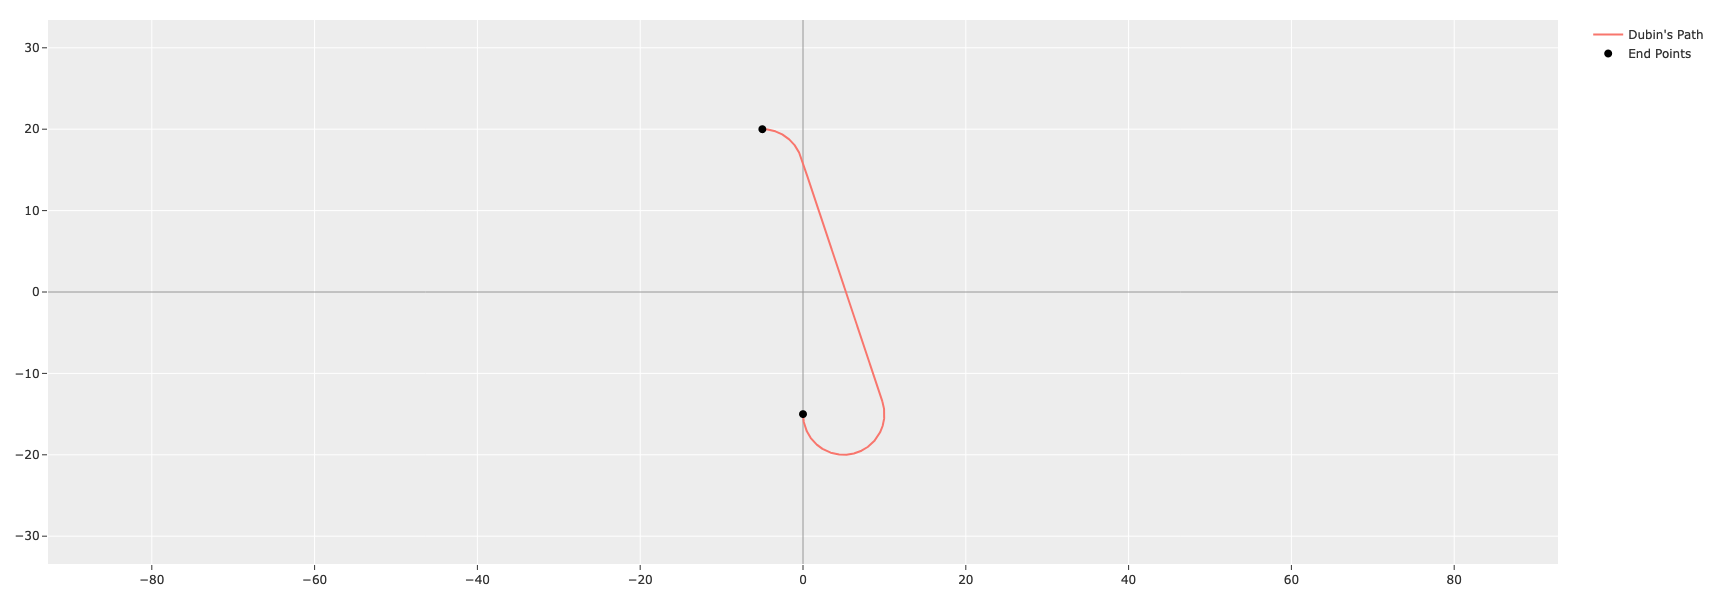

In [7]:
plot_dubin(["Dubin's Path", "lines", optimal_path]).show()

## Creating the Radars

In [8]:
radar_1 = Radar(x=-15, y=-10, v=9)
radar_2 = Radar(x=-15, y=5, v=9)

## Creating the Car Model

### Symbolicaly 

In [9]:
from sympy.abc import alpha, x, y, v, w, R, theta
from sympy import symbols, Matrix

In [10]:
d_t, s = symbols('dt, s')
a = Matrix([
    [x + d_t * s * sympy.cos(theta)],
    [y + d_t * s * sympy.sin(theta)],
    [theta]
])

A = a.jacobian(Matrix([x, y, theta]))
A

⎡1  0  -dt⋅s⋅sin(θ)⎤
⎢                  ⎥
⎢0  1  dt⋅s⋅cos(θ) ⎥
⎢                  ⎥
⎣0  0       1      ⎦

In [11]:
y_1, x_1, y_2, x_2 = symbols('y_1, x_1, y_2, x_2')
b = Matrix([
    [sympy.atan2((y - y_1), (x - x_1))],
    [sympy.atan2((y - y_2), (x - x_2))],
    [theta]
])
B = b.jacobian(Matrix([x, y, theta]))
B

⎡       -y + y₁                 x - x₁          ⎤
⎢─────────────────────  ─────────────────────  0⎥
⎢        2           2          2           2   ⎥
⎢(x - x₁)  + (y - y₁)   (x - x₁)  + (y - y₁)    ⎥
⎢                                               ⎥
⎢       -y + y₂                 x - x₂          ⎥
⎢─────────────────────  ─────────────────────  0⎥
⎢        2           2          2           2   ⎥
⎢(x - x₂)  + (y - y₂)   (x - x₂)  + (y - y₂)    ⎥
⎢                                               ⎥
⎣          0                      0            1⎦

### Create the Car

In [12]:
lti = LTI(s=1, 
          s_var=0.05, 
          dt=0.5,
          x0=optimal_path[0], 
          dubins_path=optimal_path, 
          q1=q1, 
          radar_1=radar_1, 
          radar_2=radar_2)

### Calculating the True Vehicle Path

In [13]:
lti.x_t_noise(x=[np.array([optimal_path[0]])], )

### Plotting the "True" Vehicle Path

In [14]:
simple_trajectory = [list(a) for a in lti.trajectory]

In [15]:
plot_dubin(["Dubin's Path", "lines", optimal_path], ["Vehicle", "markers", simple_trajectory]).show()

## Implementing a Simple, Noisy Bearing Calc

In [16]:
def two_radar_est(lti: LTI, radar_1: Radar, radar_2: Radar) -> list:
    from scipy.stats import multivariate_normal 
    
    y = []
    f_var = multivariate_normal(mean=np.zeros(3), cov=np.diag([radar_1.v / (RAD_2_DEGREE) ** 2, radar_2.v / (RAD_2_DEGREE) ** 2, 5 / RAD_2_DEGREE]))
    for x in lti.trajectory:
        var = f_var.rvs()
        
        state = dict(x=x[0], 
                     y=x[1],
                     theta=x[2])

        y_k = lti.measure(**state, noise_matrix=var)

        y_k = np.r_[
            y_k[0] * RAD_2_DEGREE, 
            np.linalg.norm(np.array(x[:-1]) - np.array((radar_1.x, radar_1.y))), 
            np.linalg.norm(np.array(x[:-1]) - np.array((radar_2.x, radar_2.y)))
           ]
        y.append(
            y_k
        )
    return y

### Radars at (−15, −10) and (−15, 5)

In [17]:
bearing = two_radar_est(lti, radar_1, radar_2)

#### Plotting the Bearing

In [18]:
fig = go.Figure()

fig.add_trace(
    go.Scatterpolar(
        r = [b[3] for b in bearing],
        theta = [b[0] for b in bearing],
        mode = 'markers',
        name="Radar 1"
    )
)

fig.add_trace(
    go.Scatterpolar(
        r = [b[4] for b in bearing],
        theta = [b[1] for b in bearing],
        mode = 'markers',
        name="Radar 2"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    height=600, width=600,
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    xaxis_range=[-25, 25],
    yaxis_range=[-25, 25],
)

fig.show()

#### using the bearing and the distance to plot in XY

In [19]:
x_y_1_close = [(radar_1.x + np.cos(b[0] / RAD_2_DEGREE) * b[3], radar_1.y + np.sin(b[0] / RAD_2_DEGREE) * b[3], b[2]) for b in bearing]
x_y_2_close = [(radar_2.x + np.cos(b[1] / RAD_2_DEGREE) * b[4], radar_2.y + np.sin(b[1] / RAD_2_DEGREE) * b[4], b[2]) for b in bearing]

In [20]:
fig = plot_dubin(["Dubin's Path", "lines", optimal_path], 
           ["Vehicle", "lines", simple_trajectory], 
           ["Radar 1", "markers", x_y_1_close],
           ["Radar 2", "markers", x_y_2_close])

fig.data[3].line.color = "blue"
fig.data[4].line.color = "green"

fig.add_trace(
    go.Scatter(
        x=[radar_1.x],
        y=[radar_1.y],
        name='Radar 1 Location',
        mode="markers",
        marker_size=10,
        marker_color="blue",
        marker_symbol="square"
    )
)

fig.add_trace(
    go.Scatter(
        x=[radar_2.x],
        y=[radar_2.y],
        name='Radar 2 Location',
        mode="markers",
        marker_size=10,
        marker_color="green",
        marker_symbol="square"
    )
)


fig.show()

## Estimate the Postition of the Ground Vehicle

In [21]:
R = np.diag([radar_1.v / (RAD_2_DEGREE ** 2), radar_2.v / (RAD_2_DEGREE ** 2), 5 / (RAD_2_DEGREE ** 2)])
Q = np.diag([0.05, 0.05, (1 / R_path) ** 2 * 0.5 ** 2])

In [22]:
lti.trajectory = [np.array((x[0], x[1], normalize_radians(x[2]),)) for x in lti.trajectory] 

### EKF

In [23]:
ekf = EKF(lti, R=R, Q=Q, radars=(radar_1, radar_2))
res = ekf.run("silent")

#### Plotting Computed Path vs. "Actual" Trajectory

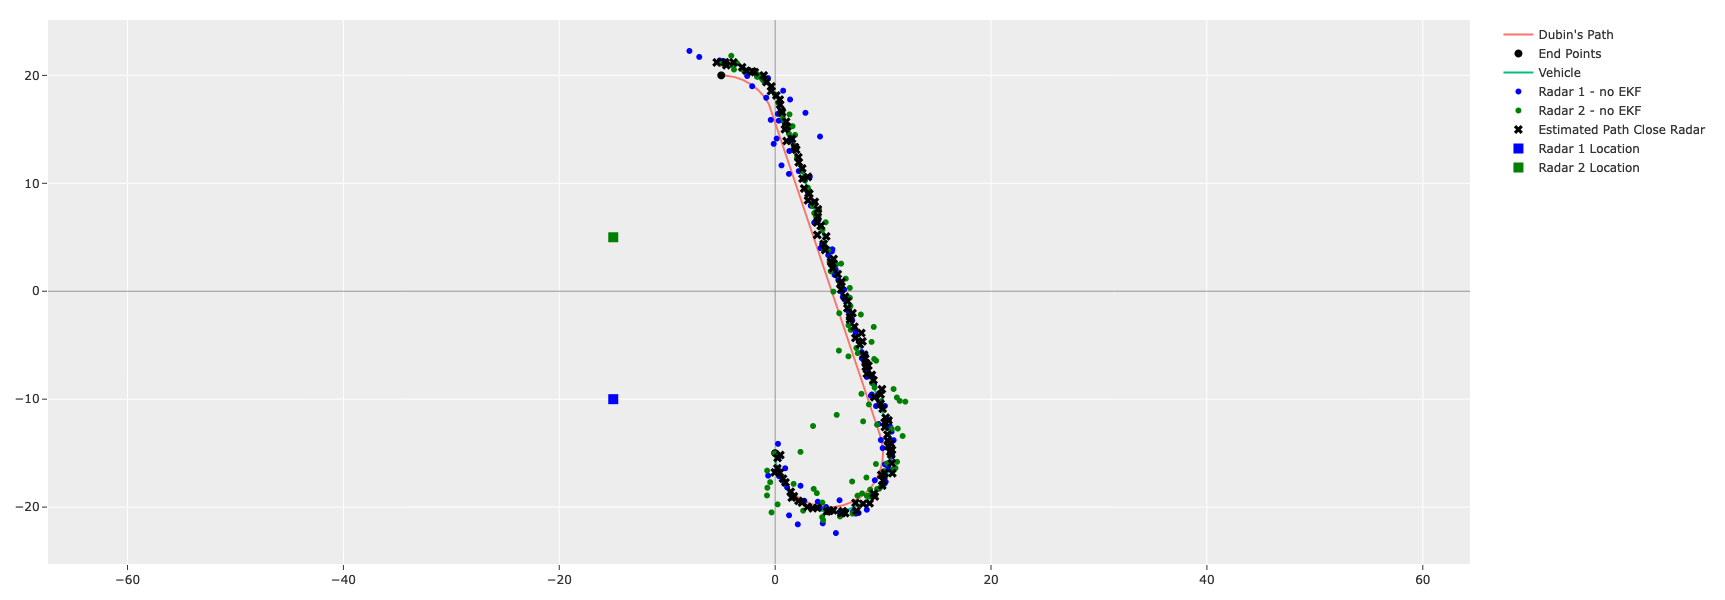

In [24]:
fig = plot_dubin(
                 ["Dubin's Path", "lines", optimal_path],
                 ["Vehicle", "lines", simple_trajectory],
                 ["Radar 1 - no EKF", "markers", x_y_1_close],
                 ["Radar 2 - no EKF", "markers", x_y_2_close],
                 ["Estimated Path Close Radar", "markers", [r.x_k_k[:, 0] for r in res]],
                 # ["Estimated Path Far Radar", "markers", [r.x_k_k.T[0] for r in res_far]],
    

)

fig.data[3].line.color = "blue"
fig.data[4].line.color = "green"

fig.add_trace(
    go.Scatter(
        x=[radar_1.x],
        y=[radar_1.y],
        name='Radar 1 Location',
        mode="markers",
        marker_size=10,
        marker_color="blue",
        marker_symbol="square"
    )
)

fig.add_trace(
    go.Scatter(
        x=[radar_2.x],
        y=[radar_2.y],
        name='Radar 2 Location',
        mode="markers",
        marker_size=10,
        marker_color="green",
        marker_symbol="square"
    )
)

fig.data[-3].marker.symbol = 'x'
fig.data[-3].marker.size = 8
fig.data[-3].marker.color = "black"

fig.update_layout(xaxis_range=None, yaxis_range=None)

fig.show()

#### Plotting with select covariance ellipse (every 3)

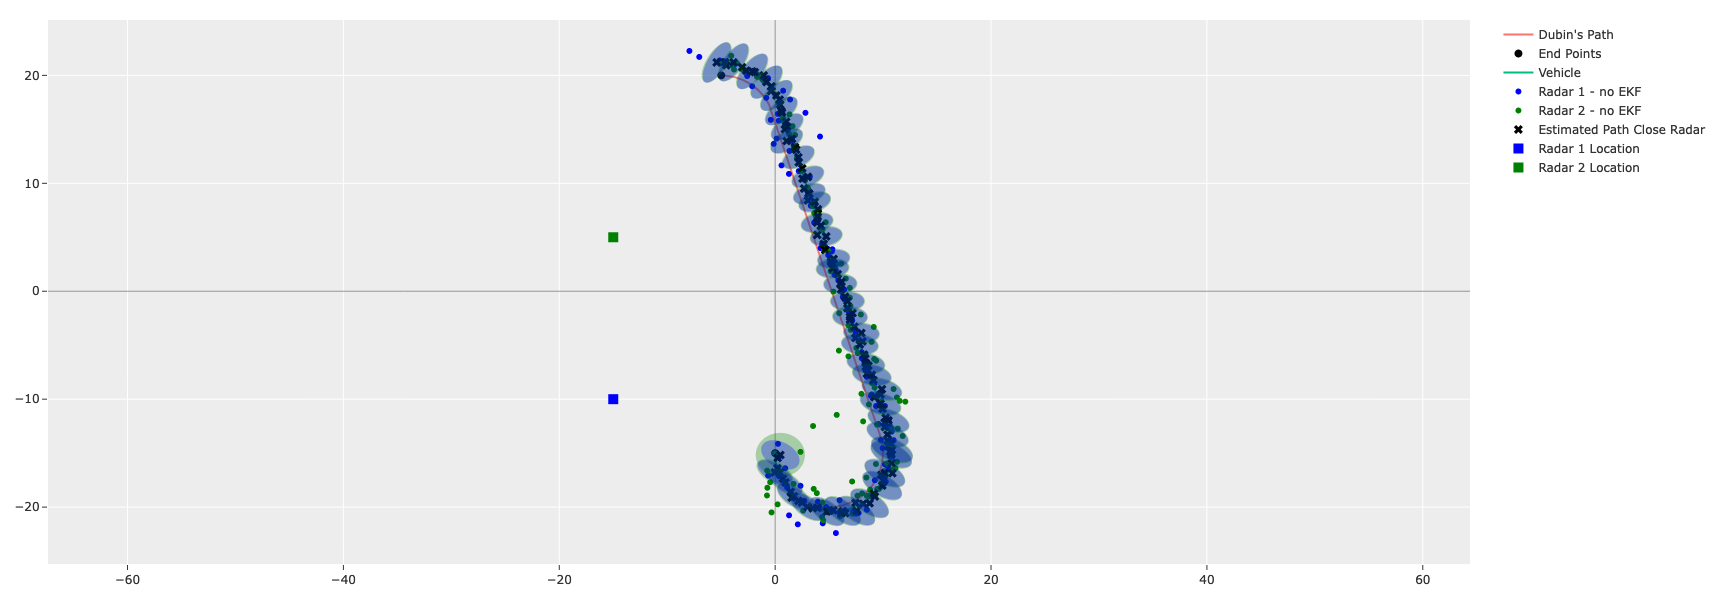

In [25]:
for _res in res[::3]:
    path = confidence_ellipse(x=_res.x_k_k[0, 0], y=_res.x_k_k[1, 0], cov=_res.P_k_k[:2, :2], n_std=2, size=50)
    priori_path = confidence_ellipse(x=_res.x_k_k[0, 0], y=_res.x_k_k[1, 0], cov=_res.P_k_k_1[:2, :2], n_std=2, size=50)
    
    fig.add_shape(
        type='path',
        path=priori_path,
        line={'dash': 'dot'},
        line_color="green",
        fillcolor="green",
    )
    
    fig.add_shape(
        type='path',
        path=path,
        line={'dash': 'dot'},
        fillcolor="blue"
    )
    

fig.show()

#### Plotting _a posteriori_ states

##### $\hat{x}_{k|k}$

In [26]:
t = [i * lti.d_t for i in range(len(res))]
x_k_k_close = [r.x_k_k[0, 0] for r in res]
x_act = [x[0] for x in simple_trajectory]
x_std_close = [r.P_k_k[0, 0] ** (1 / 2) * 2 for r in res]

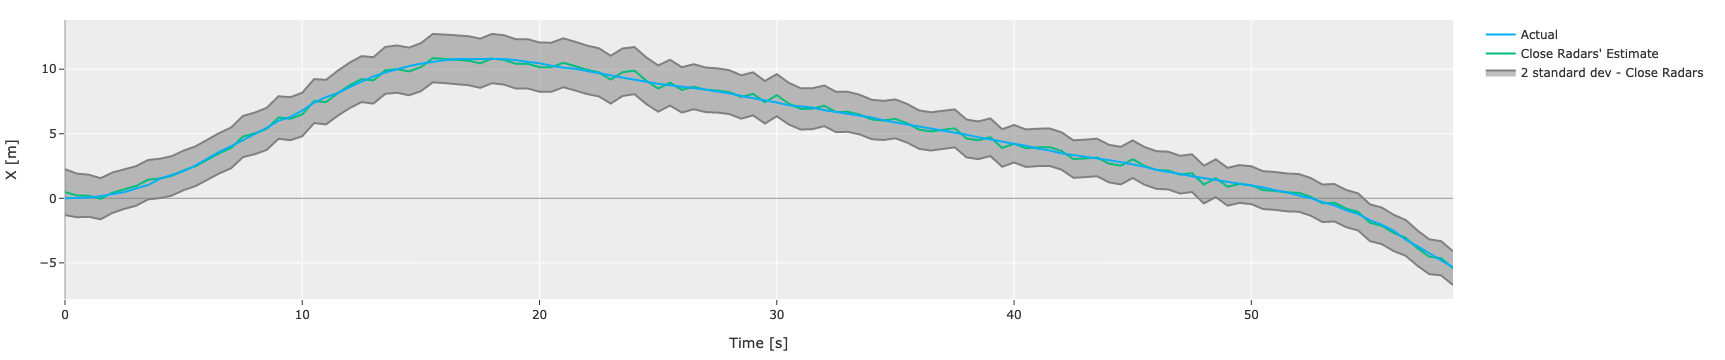

In [27]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='tonexty',
        line_color='grey',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='',
        fill='tonexty',
        line_color='grey',
        name="2 standard dev - Close Radars"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_close,
        name="Close Radars' Estimate"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_act,
        name="Actual"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="X [m]",
    xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

##### $\hat{y}_{k|k}$

In [28]:
t = [i * lti.d_t for i in range(len(res))]
x_k_k_close = [r.x_k_k[1, 0] for r in res]
x_act = [x[1] for x in simple_trajectory]
x_std_close = [r.P_k_k[1, 1] ** (1 / 2) * 2 for r in res]

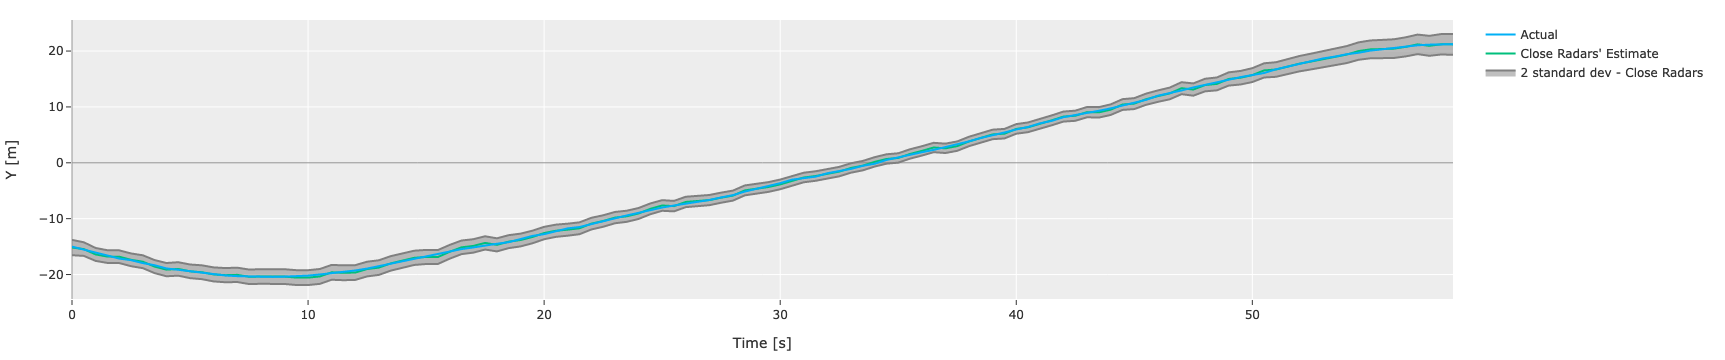

In [29]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='tonexty',
        line_color='grey',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='',
        fill='tonexty',
        line_color='grey',
        name="2 standard dev - Close Radars"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_close,
        name="Close Radars' Estimate"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_act,
        name="Actual"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="Y [m]",
    xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

##### $\hat{\theta}_{k|k}$

In [35]:
t = [i * lti.d_t for i in range(len(res))]
x_k_k_close = [r.x_k_k[2, 0] * RAD_2_DEGREE for r in res]
x_act = [x[2] * RAD_2_DEGREE for x in lti.trajectory]
x_std_close = [r.P_k_k[2, 2] ** (1 / 2) * 2 * RAD_2_DEGREE for r in res]

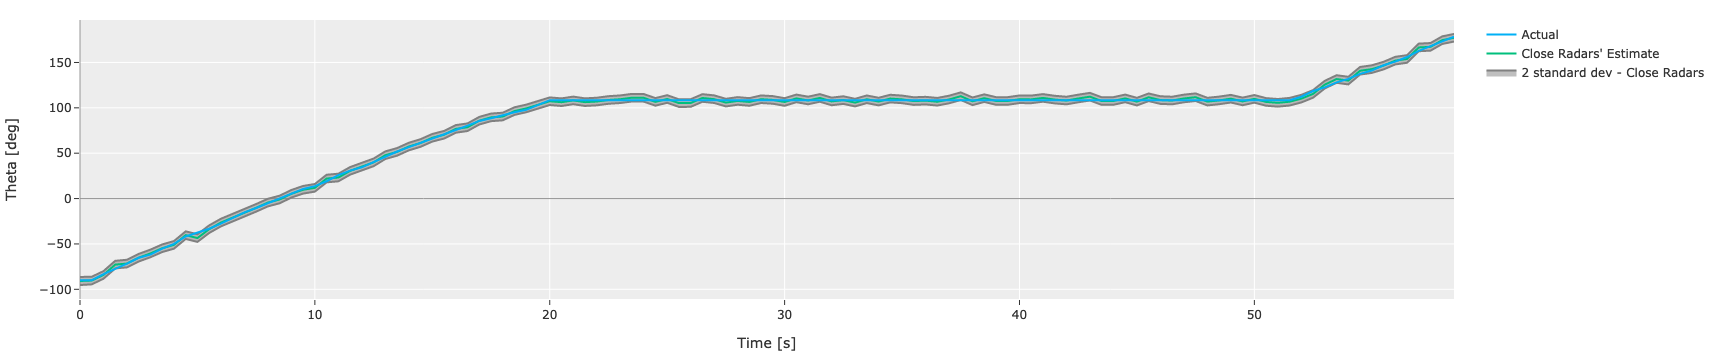

In [36]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='tonexty',
        line_color='grey',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='',
        fill='tonexty',
        line_color='grey',
        name="2 standard dev - Close Radars"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_close,
        name="Close Radars' Estimate"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_act,
        name="Actual"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="Theta [deg]",
    xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

#### Plotting the Innovation

##### $\beta_{1, k}$

In [45]:
t = [i * lti.d_t for i in range(len(res))]
x_k_k_close = [r.y_k[0, 0] * RAD_2_DEGREE for r in res]
x_std_close = [r.S_k[0, 0] ** (1 / 2) * 2 * RAD_2_DEGREE for r in res]

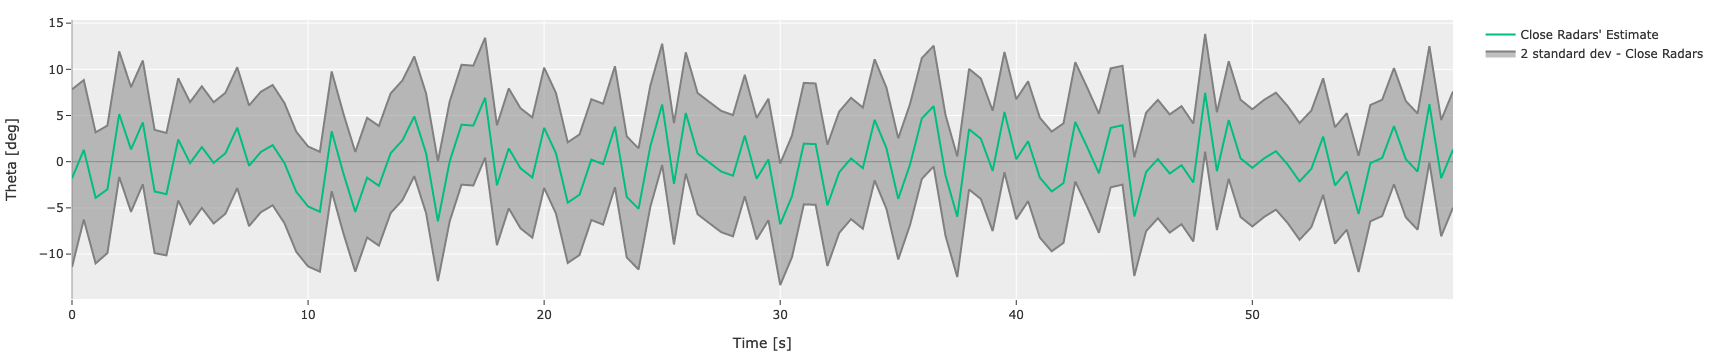

In [47]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='tonexty',
        line_color='grey',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='',
        fill='tonexty',
        line_color='grey',
        name="2 standard dev - Close Radars"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_close,
        name="Close Radars' Estimate"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="Theta [deg]",
    xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

##### $\beta_{2,k}$

In [48]:
t = [i * lti.d_t for i in range(len(res))]
x_k_k_close = [r.y_k[0, 1] * RAD_2_DEGREE for r in res]
x_std_close = [r.S_k[1, 1] ** (1 / 2) * 2 * RAD_2_DEGREE for r in res]

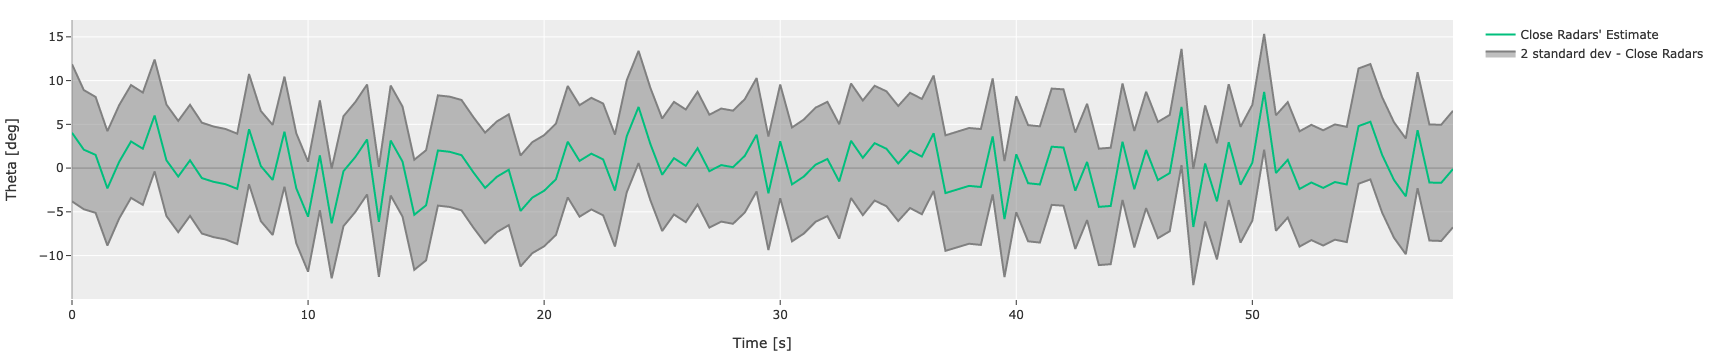

In [49]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='tonexty',
        line_color='grey',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='',
        fill='tonexty',
        line_color='grey',
        name="2 standard dev - Close Radars"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_close,
        name="Close Radars' Estimate"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="Theta [deg]",
    xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

### UKF

In [50]:
from src.ukf import UKF, SigmaPoints

In [55]:
sp = SigmaPoints(dim=lti.A.shape[0], alpha=0.001, beta=2, kappa=0)

ukf = UKF(
    sigma_obj=sp,
    x0=lti.x0,
    dim_x=lti.A.shape[0],
    dim_y=lti.C.shape[0],
    R=R,
    Q=Q, 
    fx=lti.f,
    hx=lti.measure
)

# ukf.P_priori = np.diag([0.01, 0.01, 0.01])

In [56]:
ukf.run(lti)

In [57]:
ukf.ss.keys()

dict_keys(['P_posteriori', 'P_priori', 'x_priori', 'x', 'K', 'z_res', 'z_measure', 'x_posteriori'])

#### Plotting Computed Path vs. "Actual" Trajectory

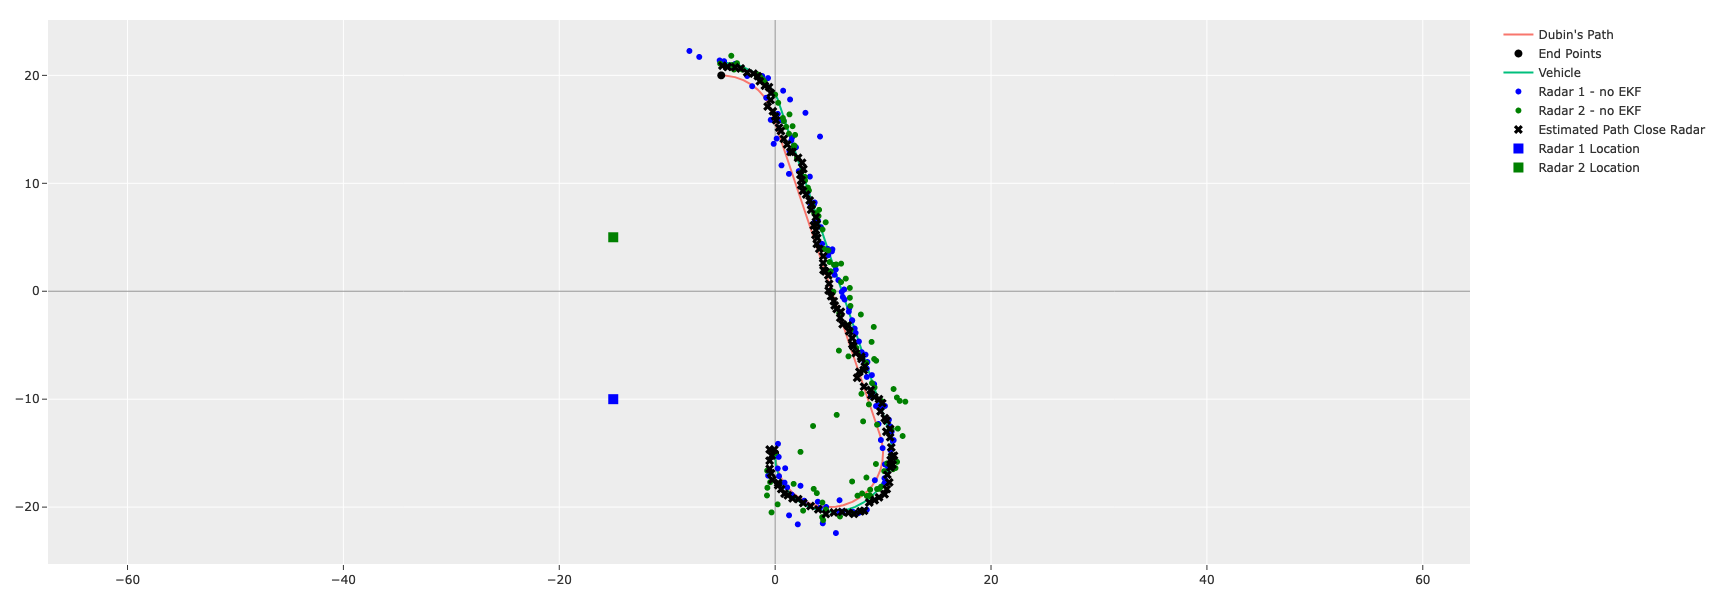

In [58]:
fig = plot_dubin(
                 ["Dubin's Path", "lines", optimal_path],
                 ["Vehicle", "lines", simple_trajectory],
                 ["Radar 1 - no EKF", "markers", x_y_1_close],
                 ["Radar 2 - no EKF", "markers", x_y_2_close],
                 ["Estimated Path Close Radar", "markers", [r for r in ukf.ss['x']]],
)

fig.data[3].line.color = "blue"
fig.data[4].line.color = "green"

fig.add_trace(
    go.Scatter(
        x=[radar_1.x],
        y=[radar_1.y],
        name='Radar 1 Location',
        mode="markers",
        marker_size=10,
        marker_color="blue",
        marker_symbol="square"
    )
)

fig.add_trace(
    go.Scatter(
        x=[radar_2.x],
        y=[radar_2.y],
        name='Radar 2 Location',
        mode="markers",
        marker_size=10,
        marker_color="green",
        marker_symbol="square"
    )
)

fig.data[-3].marker.symbol = 'x'
fig.data[-3].marker.size = 8
fig.data[-3].marker.color = "black"

fig.update_layout(xaxis_range=None, yaxis_range=None)

fig.show()

#### Plotting _a posteriori_ states

##### $\hat{x}_{k|k}$

In [66]:
t = [i * lti.d_t for i in range(len(res))]
x_k_k_close = [r[0] for r in ukf.ss['x']]
x_act = [x[0] for x in lti.trajectory]
x_std_close = [r[0, 0] ** (1 / 2) * 2 for r in ukf.ss['P_posteriori']]

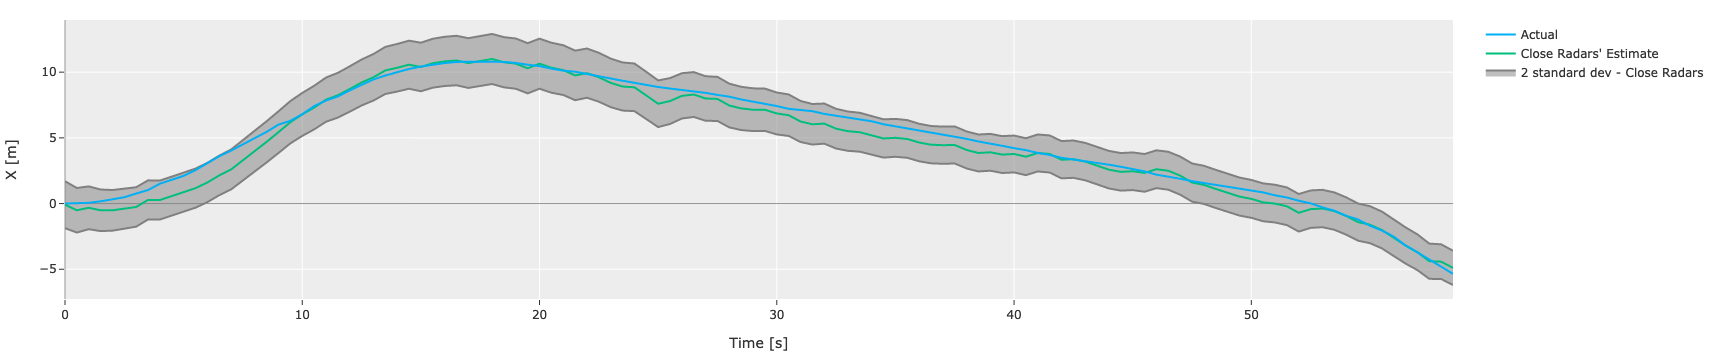

In [67]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='tonexty',
        line_color='grey',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='',
        fill='tonexty',
        line_color='grey',
        name="2 standard dev - Close Radars"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_close,
        name="Close Radars' Estimate"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_act,
        name="Actual"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="X [m]",
    xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

##### $\hat{y}_{k|k}$

In [61]:
t = [i * lti.d_t for i in range(len(res))]
x_k_k_close = [r[1] for r in ukf.ss['x']]
x_act = [x[1] for x in lti.trajectory]
x_std_close = [r[1, 1] ** (1 / 2) * 2 for r in ukf.ss['P_posteriori']]

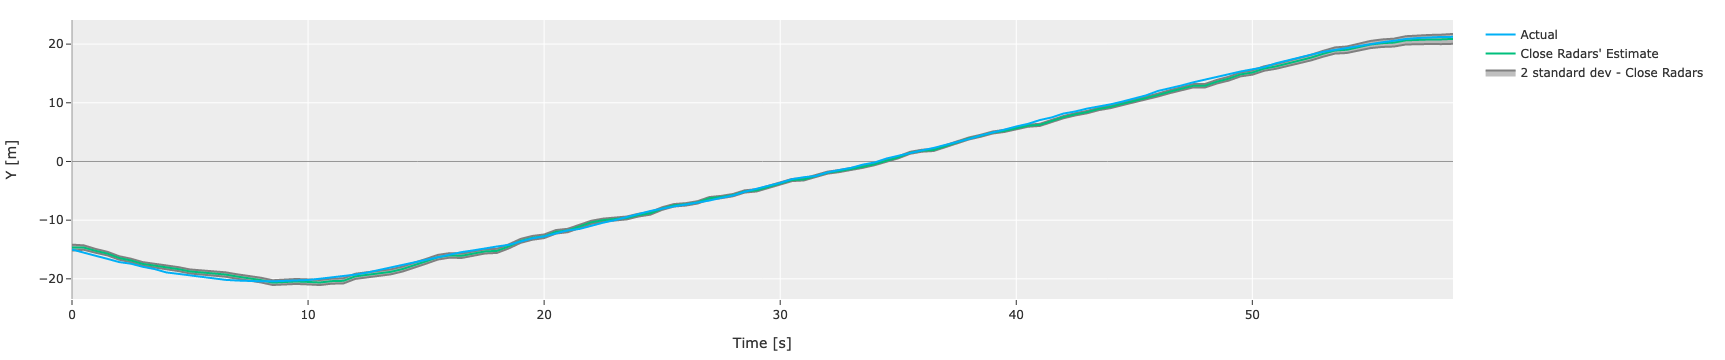

In [62]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='tonexty',
        line_color='grey',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='',
        fill='tonexty',
        line_color='grey',
        name="2 standard dev - Close Radars"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_close,
        name="Close Radars' Estimate"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_act,
        name="Actual"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="Y [m]",
    xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

##### $\hat{\theta}_{k|k}$

In [63]:
t = [i * lti.d_t for i in range(len(res))]
x_k_k_close = [r[2] * RAD_2_DEGREE for r in ukf.ss['x']]
x_act = [x[2] * RAD_2_DEGREE for x in lti.trajectory]
x_std_close = [r[2, 2] ** (1 / 2) * 2 * RAD_2_DEGREE for r in ukf.ss['P_posteriori']]

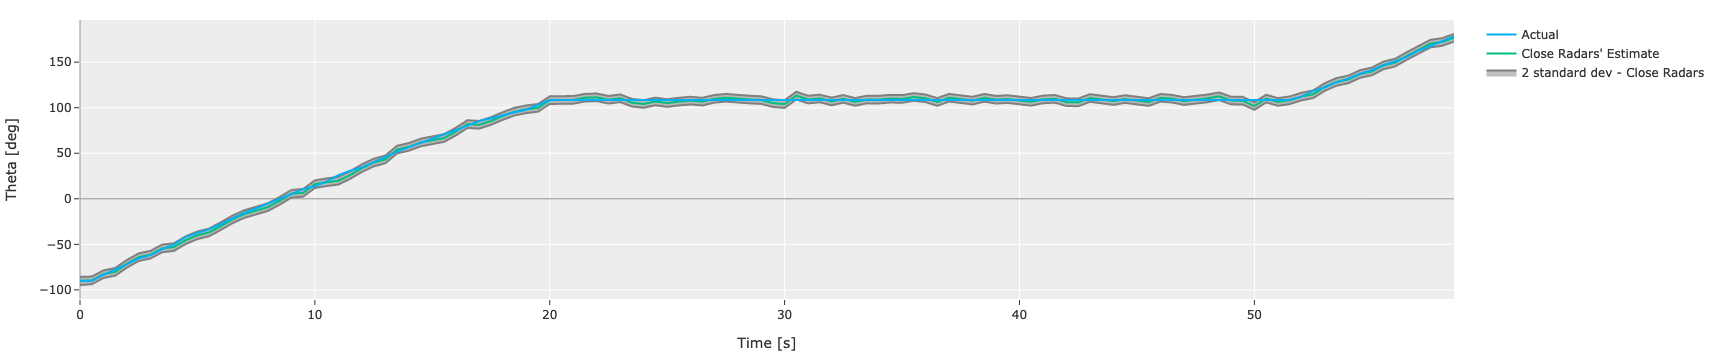

In [64]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='tonexty',
        line_color='grey',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='',
        fill='tonexty',
        line_color='grey',
        name="2 standard dev - Close Radars"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_close,
        name="Close Radars' Estimate"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_act,
        name="Actual"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="Theta [deg]",
    xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

## Comment on the plots and the differences between the sets of radars

When not using an EKF, the close radar performs better than the further radar by a wide margin. The error is most pronounced near the "hook" of the path. When using EKF, the two sets of radar (close and far) perform nearly identicaly. The covariance of the estimate is greatest in the begging, with the covariance of the _a priori_ and _a posteriori_ eventually converging